In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

from astropy.io import fits
from astropy import wcs

import healpy as hp

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/targets/sv1/resolve/dark/sv1targets-dark-hp-97.fits', columns=['BRICKID', 'RA', 'DEC', 'MASKBITS', 'WISEMASK_W1', 'PHOTSYS', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'GALDEPTH_G']))

In [4]:
field = 'south'
mask = cat['PHOTSYS']=='S'
cat = cat[mask]

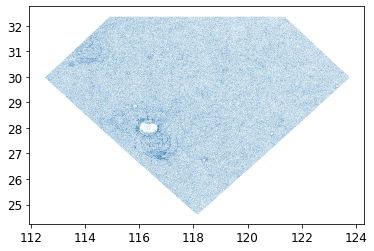

In [5]:
plt.plot(cat['RA'], cat['DEC'], '.' , ms=0.1, alpha=0.1)

In [11]:
field = 'south'

bricks = Table(fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/survey-bricks.fits.gz'))
print(len(bricks))

662174


In [12]:
cat['C_WISEMASK_W1'] = 0
cat['C_MASKBITS'] = 0
cat['C_NOBS_G'] = 0
cat['C_NOBS_R'] = 0
cat['C_NOBS_Z'] = 0
cat['C_GALDEPTH_G'] = 0.
cat['C1_WISEMASK_W1'] = 0
cat['C1_MASKBITS'] = 0
cat['C1_NOBS_G'] = 0
cat['C1_NOBS_R'] = 0
cat['C1_NOBS_Z'] = 0
cat['C1_GALDEPTH_G'] = 0.

In [14]:
# Randomly select some bricks to check

brickid_list = np.unique(cat['BRICKID'])
print(len(brickid_list))

# np.random.seed(532)
# brickid_list = np.random.choice(brickid_list, size=100, replace=False)

brickid_list = [507224, 494841, 492327, 483436, 483438, 507226, 488533, 479597,
       484718, 496090, 479586, 504756, 491077, 497354, 493593, 499833,
       479582, 504754, 478290, 496087, 488547, 492326, 507203, 489810,
       501082, 504759, 496086, 480872, 494835, 479581, 494838, 499820,
       488549, 496107, 475706, 480869, 480877, 480874, 489815, 492344,
       505999, 502303, 492333, 497355, 488545, 482152, 501066, 505980,
       506000, 497339, 475703, 498597, 497334, 470500, 493581, 491075,
       496089, 496081, 502316, 498572, 504753, 493587, 503528, 497338,
       503526, 503529, 482162, 477009, 487276, 482150, 501080, 498571,
       503530, 492317, 498594, 494851, 489811, 488534, 491059, 494837,
       498595, 493590, 479589, 491078, 488537, 503535, 501062, 480868,
       497328, 498570, 484729, 485985, 487275, 496110, 499830, 488540,
       486003, 501054, 484730, 494828]
mask = np.in1d(cat['BRICKID'], brickid_list)
cat = cat[mask]

778


In [15]:
for index, brickid in enumerate(np.unique(cat['BRICKID'])):
    
    print(index)
    
    cat_mask = cat['BRICKID']==brickid
    
    mask = bricks['BRICKID']==brickid
    brick_index = np.where(mask)[0][0]
        
    brickname = str(bricks['BRICKNAME'][brick_index])
    img_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-maskbits.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_g_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-g.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_r_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-r.fits.fz'.format(field, brickname[:3], brickname, brickname)
    nexp_z_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-nexp-z.fits.fz'.format(field, brickname[:3], brickname, brickname)
    galdepth_g_fn = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/{}/coadd/{}/{}/legacysurvey-{}-galdepth-g.fits.fz'.format(field, brickname[:3], brickname, brickname)

    hdulist = fits.open(img_fn)
    w = wcs.WCS(hdulist[1].header)
    
    maskbits = fitsio.read(img_fn, ext='MASKBITS')
    wisem1 = fitsio.read(img_fn, ext='WISEM1')
    nexp_g = fitsio.read(nexp_g_fn)
    nexp_r = fitsio.read(nexp_r_fn)
    nexp_z = fitsio.read(nexp_z_fn)
    galdepth_g = fitsio.read(galdepth_g_fn)
    
    coadd_x, coadd_y = w.wcs_world2pix(cat['RA'][cat_mask], cat['DEC'][cat_mask], 0)
    coadd_x1, coadd_y1 = coadd_x.astype(int), coadd_y.astype(int)   # as done in randoms.py
    coadd_x, coadd_y = np.round(coadd_x).astype(int), np.round(coadd_y).astype(int)  # rounding before converting to integers
    cat['C_MASKBITS'][cat_mask] = maskbits[coadd_y, coadd_x]
    cat['C_WISEMASK_W1'][cat_mask] = wisem1[coadd_y, coadd_x]
    cat['C_NOBS_G'][cat_mask] = nexp_g[coadd_y, coadd_x]
    cat['C_NOBS_R'][cat_mask] = nexp_r[coadd_y, coadd_x]
    cat['C_NOBS_Z'][cat_mask] = nexp_z[coadd_y, coadd_x]
    cat['C_GALDEPTH_G'][cat_mask] = galdepth_g[coadd_y, coadd_x]
    cat['C1_MASKBITS'][cat_mask] = maskbits[coadd_y1, coadd_x1]
    cat['C1_WISEMASK_W1'][cat_mask] = wisem1[coadd_y1, coadd_x1]
    cat['C1_NOBS_G'][cat_mask] = nexp_g[coadd_y1, coadd_x1]
    cat['C1_NOBS_R'][cat_mask] = nexp_r[coadd_y1, coadd_x1]
    cat['C1_NOBS_Z'][cat_mask] = nexp_z[coadd_y1, coadd_x1]
    cat['C1_GALDEPTH_G'][cat_mask] = galdepth_g[coadd_y1, coadd_x1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
len(cat)

89296

In [17]:
# rounding before converting to integers
print(np.all(cat['C_MASKBITS']==cat['MASKBITS']))
print(np.all(cat['C_WISEMASK_W1']==cat['WISEMASK_W1']))
print(np.all(cat['C_GALDEPTH_G']==cat['GALDEPTH_G']))

# as done in randoms.py
print(np.all(cat['C1_MASKBITS']==cat['MASKBITS']))
print(np.all(cat['C1_WISEMASK_W1']==cat['WISEMASK_W1']))
print(np.all(cat['C1_GALDEPTH_G']==cat['GALDEPTH_G']))

True
True
True
False
False
False


In [18]:
# rounding before converting to integers
print(np.sum(cat['C_MASKBITS']!=cat['MASKBITS']), np.sum(cat['C_MASKBITS']!=cat['MASKBITS'])/len(cat))
print(np.sum(cat['C_WISEMASK_W1']!=cat['WISEMASK_W1']), np.sum(cat['C_WISEMASK_W1']!=cat['WISEMASK_W1'])/len(cat))
print(np.sum(cat['C_GALDEPTH_G']!=cat['GALDEPTH_G']), np.sum(cat['C_GALDEPTH_G']!=cat['GALDEPTH_G'])/len(cat))

# as done in randoms.py
print(np.sum(cat['C1_MASKBITS']!=cat['MASKBITS']), np.sum(cat['C1_MASKBITS']!=cat['MASKBITS'])/len(cat))
print(np.sum(cat['C1_WISEMASK_W1']!=cat['WISEMASK_W1']), np.sum(cat['C1_WISEMASK_W1']!=cat['WISEMASK_W1'])/len(cat))
print(np.sum(cat['C1_GALDEPTH_G']!=cat['GALDEPTH_G']), np.sum(cat['C1_GALDEPTH_G']!=cat['GALDEPTH_G'])/len(cat))

0 0.0
0 0.0
0 0.0
230 0.0025757032789822613
72 0.000806307113420534
1311 0.014681508690198889


In [19]:
medium = cat['MASKBITS'] & 2**11>0
c_medium = cat['C_MASKBITS'] & 2**11>0
c1_medium = cat['C1_MASKBITS'] & 2**11>0

print(np.sum(medium!=c_medium), np.sum(medium!=c_medium)/len(cat))
print(np.sum(medium!=c1_medium), np.sum(medium!=c1_medium)/len(cat))

0 0.0
85 0.0009518903422325748
